**Lab 05 Analyzing neural representations**
22210802 Haeeul Hwang

In [1]:
import datasets

# load the French UD treebank
sequoia = datasets.load_dataset("universal_dependencies", "fr_sequoia", split=["train[:50%]", "test[:50%]"])
sequoia = datasets.DatasetDict({"train": sequoia[0], "test": sequoia[1]})

In [2]:
sequoia

DatasetDict({
    train: Dataset({
        features: ['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'],
        num_rows: 1116
    })
    test: Dataset({
        features: ['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'],
        num_rows: 228
    })
})

In [3]:
def reset_data(sentence):
  # words such as 'au', 'aux', 'du', 'des' etc
  words = [index for index, pos in enumerate(sentence) if pos == 13]

  # duplicate words are the ones that have a word 1 or 2 position after
  duplicates = [id for index in words for id in (index+1, index+2)]
  
  # tokens and pos tags of the sentence without the duplicates
  new_tokens = [token for i, token in enumerate(sentence["tokens"]) if i not in duplicates]
  new_pos = [pos for i, pos in enumerate(sentence["upos"]) if i not in duplicates]
  
  # give the features of the word j+2 to the word j if the word j is a contraction
  new_feats = [eval(feat) if j+2 not in duplicates else eval(sentence["feats"][j+2])
               for j, feat in enumerate(sentence["feats"]) if j not in duplicates]

  # get the number feature of the each token
  number =["None" if feat is None else feat.get("Number", "None") for feat in new_feats]
  return {"tokens": new_tokens, "pos": new_pos, "number": number}

sequoia_reset = sequoia.map(reset_data, batched=False, remove_columns=sequoia["train"].column_names)

In [4]:
# load the tokenizer and model

from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')
device = 'mps' if torch.cuda.is_available() else 'cpu'

model = model.to(device)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [5]:
# encode a text

text = "Bonjour, comment ça va ?"
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

In [6]:
def bert_tokenization(data):
  # tokenize the sentence
  word_tokens = [tokenizer.encode(word, add_special_tokens=False) for word in data["tokens"]]
  
  # get the pos tags of the word tokens
  pos_labels = [pos for i, pos in enumerate(data["pos"]) for word_length in word_tokens[i]]
  
  # get the number feature of the word tokens
  num_labels = [number for i, number in enumerate(data["number"]) for word_length in word_tokens[i]]
  
  # list of all the subword tokens
  new_tokens = [token for tokens in word_tokens for token in tokens]

  return {"tokens": new_tokens, "pos": pos_labels, "number": num_labels, "words": word_tokens}

sequoia_dataset = sequoia_reset.map(bert_tokenization, remove_columns=sequoia_reset["train"].column_names)

In [7]:
import torch

device = "mps" if torch.cuda.is_available else "cpu"

model = model.to(device)
model.eval()

def get_hidden_states(data):
  with torch.no_grad():
    out = model(input_ids=torch.tensor([data["tokens"]], device=device), output_hidden_states=True, output_attentions=True)
  hidden_states = torch.stack(out["hidden_states"])
  return {"states": hidden_states}


states = sequoia_dataset.map(get_hidden_states)

In [8]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# train the linguistic probes for each layer

for layer in range(13):
    print(f"LAYER {layer}")
    
    X_train = [embed for states in states["train"]["states"] for embed in states[layer][0]]
    X_test = np.array([embed for states in states["test"]["states"] for embed in states[layer][0]])
    
    y_train_pos = [pos for sentence in sequoia_dataset["train"]["pos"] for pos in sentence]
    y_test_pos = np.array([pos for sentence in sequoia_dataset["test"]["pos"] for pos in sentence])
    
    y_train_num = [num for sentence in sequoia_dataset["train"]["number"] for num in sentence]
    y_test_num = np.array([num for sentence in sequoia_dataset["test"]["number"] for num in sentence])
    
    # train a probe for the pos tags
    pos_probe = LogisticRegression(max_iter=1000)
    pos_probe.fit(X_train, y_train_pos)
    print(f"pos_accuracy: {pos_probe.score(X_test, y_test_pos)}")
    
    # train a probe for the number feature
    num_probe = LogisticRegression(max_iter=1000)
    num_probe.fit(X_train, y_train_num)
    print(f"num_accuracy: {num_probe.score(X_test, y_test_num)}")
    

LAYER 0


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


pos_accuracy: 0.790875052003883
num_accuracy: 0.8231867979475801
LAYER 1


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


pos_accuracy: 0.8464845375121343
num_accuracy: 0.846207183469699
LAYER 2


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


pos_accuracy: 0.8786576064346138
num_accuracy: 0.8650672583552905
LAYER 3


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


pos_accuracy: 0.9123561225904867


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


num_accuracy: 0.8933573706836777
LAYER 4


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


pos_accuracy: 0.9291360421578144


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


num_accuracy: 0.8989044515323811
LAYER 5


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


pos_accuracy: 0.9317709055609485


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


num_accuracy: 0.9145749549299681
LAYER 6


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


pos_accuracy: 0.9310775204548606


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


num_accuracy: 0.918596588545278
LAYER 7


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


pos_accuracy: 0.9339897379004299


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


num_accuracy: 0.9165164332270143
LAYER 8


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


pos_accuracy: 0.9335737068367771


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


num_accuracy: 0.9161004021633615
LAYER 9


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


pos_accuracy: 0.9267785327971155


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


num_accuracy: 0.9077797808903065
LAYER 10


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


pos_accuracy: 0.9187352655664957


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


num_accuracy: 0.9093052281236998
LAYER 11


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


pos_accuracy: 0.9181805574816253


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


num_accuracy: 0.9081958119539593
LAYER 12


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


pos_accuracy: 0.9095825821661351
num_accuracy: 0.8982110664262931


In [9]:
pos_acc = [0.790875052003883, 0.8464845375121343, 0.8786576064346138, 0.9123561225904867, 0.9291360421578144, 0.9317709055609485, 
           0.9310775204548606, 0.9339897379004299, 0.9335737068367771, 0.9267785327971155, 0.9187352655664957, 0.9181805574816253, 0.9095825821661351]
num_acc = [0.8231867979475801, 0.846207183469699, 0.8650672583552905, 0.8933573706836777, 0.8989044515323811, 0.9145749549299681, 
           0.918596588545278, 0.9165164332270143, 0.9161004021633615, 0.9077797808903065, 0.9093052281236998, 0.9081958119539593, 0.8982110664262931]

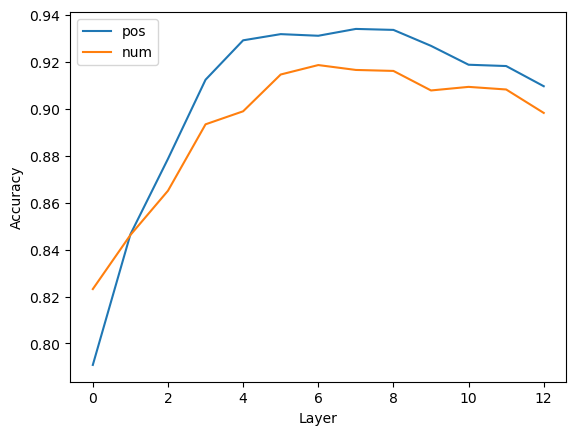

In [10]:
# plot the accuracy of the linguistic probes for each layer

import matplotlib.pyplot as plt

plt.plot(range(13), pos_acc, label="pos")
plt.plot(range(13), num_acc, label="num")
plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Both PoS and number prediction accuracy generally increase as you move from the embedding layer (layer 0) to higher layers.
PoS tagging accuracy reaches its peak around layer 6 and remains relatively high with slight fluctuations up to layer 12.
Number prediction accuracy also increases, peaking around layer 5-6 and then shows a gradual decline or plateau with slight variations towards layer 12.

The initial layers (0-2) show a significant increase in accuracy for both PoS tagging and number prediction, indicating that these layers start capturing useful linguistic information early on.
The middle layers (3-6) are the most effective for both tasks, suggesting that these layers capture the most relevant features for PoS and number information.
The accuracy stabilizes or slightly decreases in the upper layers (7-12), which might imply that these layers are more specialized or capture higher-level features less relevant to these specific tasks.

The middle layers (around 4-6) of mBERT are most effective in capturing linguistic information such as PoS and number features. This aligns with the understanding that middle layers in BERT-like models tend to capture syntactic information effectively.